In [38]:
from models import deep_strain_model
from datasets import base_dataset
from datasets.nifti_dataset import resample_nifti
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import center_of_mass
from datasets.base_dataset import roll_and_pad_256x256_to_center_inv
from datasets.base_dataset import _roll2center_crop
from scipy.ndimage import gaussian_filter
import numpy as np
import SimpleITK as sitk
from utils.strain_from_motion import *
from utils.utils_aha import *
import nibabel as nib
from skimage.util import montage
import matplotlib.pyplot as plt
import os

########################## Mask and normalization ######################################


def normalize(x, axis=(0, 1, 2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x - mu) / (sd + 1e-8)


def get_mask(V, netS):
    nx, ny, nz, nt = V.shape

    M = np.zeros((nx, ny, nz, nt))
    v = V.transpose((2, 3, 0, 1)).reshape((-1, nx, ny))  # (nz*nt,nx,ny)
    v = normalize(v)
    for t in range(nt):
        for z in range(nz):
            m = netS(
                v[z * nt + t, nx // 2 - 64 : nx // 2 + 64, ny // 2 - 64 : ny // 2 + 64][
                    None, ..., None
                ]
            )
            M[nx // 2 - 64 : nx // 2 + 64, ny // 2 - 64 : ny // 2 + 64, z, t] += (
                np.argmax(m, -1).transpose((1, 2, 0)).reshape((128, 128))
            )
    return M

######################### Constants and arguments ######################################

DATASET_FOLDER = "ACDC"

class CarSON_options:
    def __init__(self):
        self.isTrain = False
        self.image_shape = (128, 128, 1)
        self.nlabels = 4
        self.pretrained_models_netS = "models/carson_Jan2021.h5"
        self.pretrained_models_netME = "models/carmen_Jan2021.h5"


class CarMEN_options:
    def __init__(self):
        self.isTrain = False
        self.volume_shape = (128, 128, 16, 1)
        self.pretrained_models_netS = "models/carson_Jan2021.h5"
        self.pretrained_models_netME = "models/carmen_Jan2021.h5"

In [ ]:
opt = CarSON_options()
model = deep_strain_model.DeepStrain(Adam, opt=opt)
netS = model.get_netS()

out_folder = "data/training/"
patients = [f"patient{i:03d}" for i in range(1, 101)]

for patient in patients:
    print(f"Segmentation on patient {patient}")
    V_nifti = nib.load(os.path.join(DATASET_FOLDER, patient, f"{patient}_4d.nii.gz"))
    V_nifti_resampled = resample_nifti(
        V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16
    )

    V = V_nifti_resampled.get_fdata()
    V = normalize(V, axis=(0, 1))
    M = get_mask(V, netS)

    center_resampled = center_of_mass(M[:, :, :, 0] == 2)
    V = base_dataset.roll_and_pad_256x256_to_center(x=V, center=center_resampled)
    M = base_dataset.roll_and_pad_256x256_to_center(x=M, center=center_resampled)
    center_resampled_256x256 = center_of_mass(M == 3)

    M = get_mask(V, netS)[128 - 64 : 128 + 64, 128 - 64 : 128 + 64]
    V = V[128 - 64 : 128 + 64, 128 - 64 : 128 + 64]

    M_nifti = nib.Nifti1Image(M, V_nifti_resampled.affine)
    V_nifti = nib.Nifti1Image(V, V_nifti_resampled.affine)

    M_nifti.to_filename(os.path.join(out_folder, f"{patient}_seg.nii.gz"))
    V_nifti.to_filename(os.path.join(out_folder, f"{patient}.nii.gz"))

(128, 128, 16, 34)

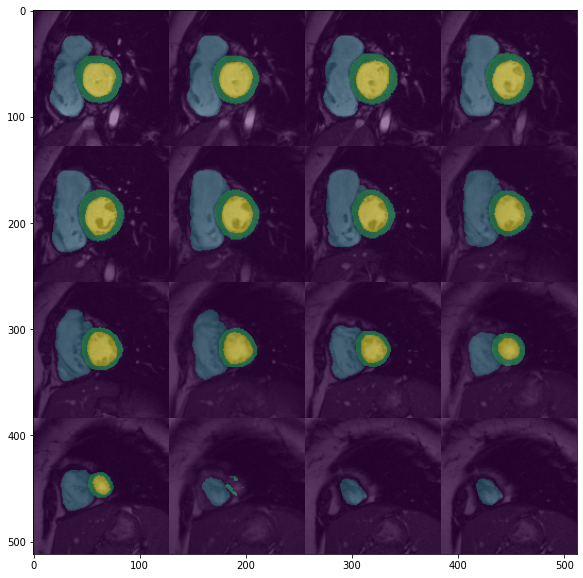

In [43]:
volume = V_nifti.get_fdata()
mask = M_nifti.get_fdata()
plt.figure(figsize=(10, 10))
plt.imshow(montage(volume[:, :, :, 0].transpose()), cmap="gray")
plt.imshow(montage(mask[:, :, :,0].transpose()), alpha=0.5)
M.shape

Data  that will be used for training is in ACDC folder

In [1]:
from models import deep_strain_model
from datasets import base_dataset
from datasets.nifti_dataset import resample_nifti
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import center_of_mass
from datasets.base_dataset import roll_and_pad_256x256_to_center_inv
from datasets.base_dataset import _roll2center_crop
from scipy.ndimage import gaussian_filter
import numpy as np
import SimpleITK as sitk
from utils.strain_from_motion import *
from utils.utils_aha import *
import nibabel as nib
from skimage.util import montage
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K 
from models.dense_image_warp import dense_image_warp3d as warp
from models.networks import *
import os

##########################      Normalization     ######################################


def normalize(x, axis=(0, 1, 2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x - mu) / (sd + 1e-8)

######################### Constants and arguments ######################################

def tf_gradient_3d(a):
    #*axis = 1
    left = tf.concat([a[:,1:], tf.expand_dims(a[:,-1],1)], axis = 1)
    right = tf.concat([tf.expand_dims(a[:,0],1), a[:,:-1]], axis = 1)

    ones = tf.ones_like(right[:, 2:], tf.float64)
    one = tf.expand_dims(ones[:,0], 1)
    dx = tf.concat((one, ones*2, one), 1)

    gy = (left - right )/dx

    #* axis = 0
    left = tf.concat([a[1:,:], tf.expand_dims(a[-1,:],0)], axis = 0)
    right = tf.concat([tf.expand_dims(a[0,:],0), a[:-1,:]], axis = 0)
   
    ones = tf.ones_like(right[2:], tf.float64)
    one = tf.expand_dims(ones[0], 0)
    dx = tf.concat((one, ones*2, one), 0)

    gx = (left - right )/dx

    # *axis = 2
    left = tf.concat([a[:,:,1:], tf.expand_dims(a[:,:,-1],2)], axis = 2)
    right = tf.concat([tf.expand_dims(a[:,:,0],2), a[:,:,:-1]], axis = 2)
    
    ones = tf.ones_like(right[:, :, 2:], tf.float64)
    one = tf.expand_dims(ones[:,:,0], 2)
    dx = tf.concat((one, ones*2, one), 2)

    gz = (left - right )/dx

    return gx, gy, gz


def criterion_netME(y_true, y_pred):
    u = y_pred
    V_0, V_t, M_0, M_t, res = y_true

    V_t_pred = warp(V_t, u)

    M_t_split = tf.split(M_t, M_t.shape[-1], -1)
    M_0_pred  = K.concatenate([warp(K.cast(mt, K.dtype(V_t)), u) for mt in M_t_split], -1)    
    M_0_pred  = keras.activations.softmax(M_0_pred)

    lambda_i = 0.1
    lambda_a = 0.1
    lambda_s = 0.1

    # Intensity loss
    L_i = K.mean(K.abs(V_t_pred - V_0))

    # Anatomical loss
    L_a = K.mean(K.abs(M_0_pred - M_0))

    # Smoothness loss
    ux, uy, uz = tf_gradient_3d(u[..., 0])
    vx, vy, vz = tf_gradient_3d(u[..., 1])
    wx, wy, wz = tf_gradient_3d(u[..., 2])

    u_dot_res = ux * res[..., 0] + uy * res[..., 1] + uz * res[..., 2]
    v_dot_res = vx * res[..., 0] + vy * res[..., 1] + vz * res[..., 2]
    w_dot_res = wx * res[..., 0] + wy * res[..., 1] + wz * res[..., 2]

    L_s = K.mean(K.abs(u_dot_res)) + K.mean(K.abs(v_dot_res)) + K.mean(K.abs(w_dot_res))

    return lambda_i * L_i + lambda_a * L_a + lambda_s * L_s

def criterion_netME1(y_true, y_pred):
    u = y_pred
    V_0, V_t, M_0, M_t, res = y_true

    V_t_pred = warp(V_t, u)

    M_t_split = tf.split(M_t, M_t.shape[-1], -1)
    M_0_pred  = K.concatenate([warp(K.cast(mt, K.dtype(V_t)), u) for mt in M_t_split], -1)    
    M_0_pred  = keras.activations.softmax(M_0_pred)

    lambda_i = 0.1
    lambda_a = 0.1
    lambda_s = 0.1

    dice = Dice()
    grad = Grad()

    # Intensity loss
    L_i = K.mean(K.abs(V_t_pred - V_0))

    # Anatomical loss
    L_a = Dice.loss(M_0, M_0_pred)

    # Smoothness loss
    L_s = grad.loss([],u)

    return lambda_i * L_i + lambda_a * L_a + lambda_s * L_s

class CarMEN_options:
    def __init__(self):
        self.isTrain = True
        self.volume_shape = (128, 128, 16, 1)
        self.criterion_netME = criterion_netME
        self.netME_lr = 1e-4


In [2]:
opt = CarMEN_options()
model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()


In [3]:
######################### Data loading ######################################
DATA_FOLDER = 'data/training'

volumes_nifti = [nib.load(os.path.join(DATA_FOLDER, f"patient{i:03d}.nii.gz")) for i in range(1, 101)]
segs_nifti = [nib.load(os.path.join(DATA_FOLDER, f"patient{i:03d}_seg.nii.gz")) for i in range(1, 101)]

In [4]:
volumes = [v.get_fdata() for v in volumes_nifti]
segs = [s.get_fdata() for s in segs_nifti]
reslist = [np.full(shape=(128,128,16,3), fill_value=v.header.get_zooms()[:-1]) for v in volumes_nifti]


In [5]:
# x_train is a list of multiple list of 2 3D volumes, one at time 0 and one at time t
# y_train is a list of multiple list of 3D volumes, one at time 0, one at time t and one segmentation at time t

In [6]:
x_train = np.array([[v[..., 0][None, ..., None], v[..., t][None, ..., None]] for v in volumes for t in range(1, v.shape[-1])])

In [8]:
np.shape(x_train)

(2598, 2, 1, 128, 128, 16, 1)

In [9]:
y_train = np.array([[[v[..., 0][None, ..., None], v[..., t][None, ..., None], s[..., 0][None, ..., None], s[..., t][None, ..., None]]] for v, s in zip(volumes, segs) for t in range(1, v.shape[-1])])

In [7]:
np.shape(y_train)

NameError: name 'y_train' is not defined

In [10]:
netME.fit(x_train, y_train, batch_size=2, epochs=1, verbose=2)

: 

: 

In [16]:
import numpy as np
np.full(shape=(128,128,16,3), fill_value=(1,2,3))

array([[[[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         ...,
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         ...,
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         ...,
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        ...,

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         ...,
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         ...,
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         ...,
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]]],


       [[[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         ...,
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1,